### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [302]:
import pandas as pd
import numpy as np

# 2.0 Data Collection

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-09-23 13:18:01--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv’

100%[======================================>] 1,423,529   --.-K/s   in 0.006s  

2023-09-23 13:18:01 (223 MB/s) - ‘housing.csv’ saved [1423529/1423529]



In [303]:
df=pd.read_csv('housing.csv')

# 2.1 Data Preparation

In [304]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<Axes: xlabel='median_house_value', ylabel='Count'>

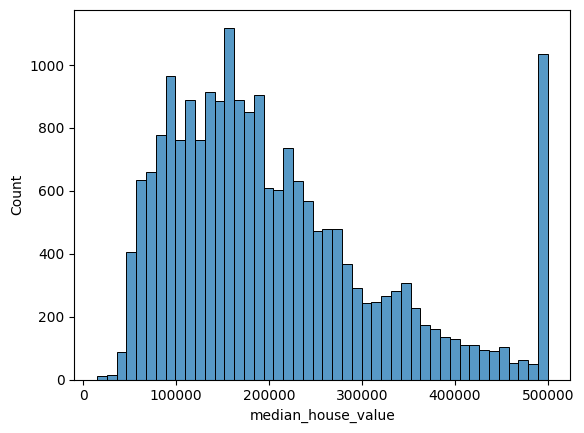

In [305]:
#checking if the data has a long tail -> R: Yes, it has, at the end.
import seaborn as sns
sns.histplot(df['median_house_value'])

# 2.2 Preparing the dataset

In [311]:
#First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'
df_sub = df[df.ocean_proximity.isin(['<1H OCEAN' , 'INLAND'])]
df_sub = df_sub.reset_index(drop=True)
df_sub.ocean_proximity.unique()

array(['<1H OCEAN', 'INLAND'], dtype=object)

In [312]:
'''
Next, use only the following columns:
    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value'
'''
features=[
    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value'
]

In [313]:
df_sub = df_sub[features]

## Question 1

In [314]:
#There's one feature with missing values. What is it?
df_sub.isnull().sum()
#R: total_bedrooms

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

## Question 2

In [315]:
#What's the median (50% percentile) for variable 'population'?
df_sub.population.median()
#R = 1195

1195.0

# 2.3 Split the Dataset

In [316]:
'''
    Shuffle the dataset (the filtered one you created above), use seed 42.
    Split your data in train/val/test sets, with 60%/20%/20% distribution.
    Apply the log transformation to the median_house_value variable using the np.log1p() function.
'''
#Shuffling data
df_sub = df_sub.sample(frac=1, random_state=42)

In [317]:
#Splitting data into train, validation and test
df_sub
n = len(df_sub)
n_val=int(n*0.2) #%20
n_test=int(n*0.2) #%20
n_train=n-n_val-n_test

In [319]:
n, n_val+n_test+n_train

(15687, 15687)

In [320]:
df_val=df_sub.iloc[:n_val]
df_test=df_sub.iloc[n_val:n_val+n_test]
df_train=df_sub.iloc[n_val+n_test:]

In [321]:
len(df_val),len(df_test),len(df_train)

(3137, 3137, 9413)

In [322]:
#Applying the log transformation
y_train=np.log1p(df_train.median_house_value.values)
y_val=np.log1p(df_val.median_house_value.values)
y_test=np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

## Question 3

In [58]:
#We need to deal with missing values for the column from Q1.
#Which option gives better RMSE? -> Filling with 0 or imputing with mean?
#Filling with 0 = 0.3368 626196050097
#Imputing with mean = 0.3367 762082545984
#R: Considering 2 decimal digits, they are the same.
def train_linear_regression(X, y):
    ones=np.ones(X.shape[0])
    X=np.column_stack([ones,X])
    
    XTX=X.T.dot(X)
    XTX_inv=np.linalg.inv(XTX)
    w=XTX_inv.dot(X.T).dot(y)
    
    return w[0],w[1:]

In [59]:
def rmse(y, y_pred):
    se = (y - y_pred)**2
    mse=se.mean()
    return np.sqrt(mse)

In [ ]:
features.remove('median_house_value')
features

In [98]:
def prepare_X_zero(df):
    X = df[features].fillna(0).values
    return X

In [225]:
#filling with 0
X_train=prepare_X_zero(df_train)
w0, w = train_linear_regression(X_train,y_train)

X_val = prepare_X_zero(df_val) 
y_pred = w0+X_val.dot(w)

score = rmse(y_val,y_pred)
round(score, 3)

0.335

In [153]:
df_train.columns

Index(['latitude', 'longitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')

In [163]:
#imputing with mean
def prepare_X_mean(df_mean):
    df_out=df_mean.copy()
    for column in df_out.columns:
        media = df_train[column].mean()
        df_out[column].fillna(media,inplace=True)
    return df_out.values

In [170]:
#checking the RMSE
X_train=prepare_X_mean(df_train)
w0, w = train_linear_regression(X_train,y_train)

X_val = prepare_X_mean(df_val)
y_pred = w0+X_val.dot(w)

score = rmse(y_val,y_pred)
round(score, 2)

0.34

## Question 4

In [209]:
#R: the best r, in this case, is 0.000001
'''

    Now let's train a regularized linear regression.
    For this question, fill the NAs with 0.
    Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
    Use RMSE to evaluate the model on the validation dataset.
    Round the RMSE scores to 2 decimal digits.
    Which r gives the best RMSE?

'''
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones,X])
    
    XTX = X.T.dot(X)
    XTX = XTX + (np.eye(XTX.shape[0]) * r)
    
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0],w[1:]

In [210]:
def get_best_r():
    best_r=0
    best_score=10000
    for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
        X_train = prepare_X_zero(df_train) 
        w0,w = train_linear_regression_reg(X_train,y_train,r=r) #fit

        X_val = prepare_X_zero(df_val) 
        y_pred = w0 + X_val.dot(w)

        score = rmse(y_val,y_pred)
        score = round(score, 2)
        
        if(score < best_score):
                best_score = score
                best_r = r
        print("rs: ", r, "| score:", score)
    

In [211]:
get_best_r()

rs:  0 | score: 0.34
rs:  1e-06 | score: 0.34
rs:  0.0001 | score: 0.34
rs:  0.001 | score: 0.34
rs:  0.01 | score: 0.34
rs:  0.1 | score: 0.34
rs:  1 | score: 0.34
rs:  5 | score: 0.34
rs:  10 | score: 0.34


## Question 5

In [ ]:
#R: 0.005. It can vary.
'''
    We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
    Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
    For each seed, do the train/validation/test split with 60%/20%/20% distribution.
    Fill the missing values with 0 and train a model without regularization.
    For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
    What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
    Round the result to 3 decimal digits (round(std, 3))
'''
#Shuffling data.
#Seed = 0. RMSE = 0.3448608802161421
#Seed = 1. RMSE = 0.36220965229938007
#Seed = 2. RMSE = 0.3374856671811416
#Seed = 3. RMSE = 0.33049372938415095
#Seed = 4. RMSE = 0.34010830759704214
#Seed = 5. RMSE = 0.33371958002363145
#Seed = 6. RMSE = 0.3360690274188254
#Seed = 7. RMSE = 0.344578787650218
#Seed = 8. RMSE = 0.33673204523735806
#Seed = 9. RMSE = 0.3358829158251305

a=[]
for i in range(0,10):
    idx=np.arange(n)
    np.random.seed(i)
    np.random.shuffle(idx)
    
    n = len(df_sub)
    n_val=int(n*0.2) #%20
    n_test=int(n*0.2) #%20
    n_train=n-n_val-n_test

    df_train=df_sub.iloc[idx[:n_train]]
    df_val=df_sub.iloc[idx[n_train:n_train+n_val]]
    df_test=df_sub.iloc[idx[n_train+n_val:]]
    
    df_train=df_train.reset_index(drop=True)
    df_val=df_val.reset_index(drop=True)
    df_test=df_test.reset_index(drop=True)

    y_train=np.log1p(df_train.median_house_value.values)
    y_val=np.log1p(df_val.median_house_value.values)
    y_test=np.log1p(df_test.median_house_value.values)

    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']

    #filling with 0
    X_train=prepare_X_zero(df_train)
    w0, w = train_linear_regression(X_train,y_train)

    X_val = prepare_X_zero(df_val) 
    y_pred = w0+X_val.dot(w)

    score = rmse(y_val,y_pred)
    a.append(score)
    
print(a)

In [288]:
std=np.std(a)
round(std,3)

0.006

## Question 6

In [350]:
#R = 0.33498993366147484
idx=np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

n = len(df_sub)
n_val=int(n*0.2) #%20
n_test=int(n*0.2) #%20
n_train=n-n_val-n_test

df_train=df_sub.iloc[idx[:n_train]]
df_val=df_sub.iloc[idx[n_train:n_train+n_val]]
df_test=df_sub.iloc[idx[n_train+n_val:]]

df_train=df_train.reset_index(drop=True)
df_val=df_val.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)
df_full=pd.concat([df_train, df_val], ignore_index=True)

y_train=np.log1p(df_train.median_house_value.values)
y_val=np.log1p(df_val.median_house_value.values)
y_test=np.log1p(df_test.median_house_value.values)
y_full=np.log1p(df_full.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']
del df_full['median_house_value']

df_full

#filling with 0
X_full=prepare_X_zero(df_full)
w0, w = train_linear_regression_reg(X_full,y_full,r=0.001)

X_test = prepare_X_zero(df_test) 
y_pred = w0+X_test.dot(w)

score = rmse(y_test,y_pred)
score

0.33498993366147484